In [16]:
import matplotlib.pyplot as plt
import paraview.simple as pvs
import pandas as pd
import numpy as np
import math
from pathlib import Path
from SALib.analyze import morris
from SALib.sample.morris import sample

from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms

# Biocellion Output Plotting
This notebook defines functions to read and plot the biocellion output data for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  

To use these plotting functions the biocellion output summary should be in one directory with the following naming pattern:
`output_parameter{par_id}_trial{trial}.txt`

If the scripts and instructions in https://github.com/TheCMMC/biocellion-tools have been used to create the output, this notebook should be able to run with the resulting data.

## User settings

In [44]:
# Set this data folder to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-data")
MODEL_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user")
TOOLS_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-tools")
FIG_FOLDER = Path("./figures")

In [45]:
ABM_ONLY_DATA_FOLDER = DATA_FOLDER / "PLOSone_ABM-only-microcarrier"
ABM_ONLY_MODEL_FOLDER = MODEL_FOLDER / "ABM-only-microcarriers"

ABM_CFD_DATA_FOLDER = DATA_FOLDER / "PLOSone_ABM-CFD-microcarrier"
ABM_CFD_MODEL_FOLDER = MODEL_FOLDER / "ABM-microcarriers"
ABM_CFD_PARAMETER_FILE = TOOLS_FOLDER / "SensitivityAnalysis_ABM-CFD_ParameterInfo.csv"

In [46]:
color_dict={'live': '#1f77b4', 'attached': '#2ca02c', 'dead': '#ff7f0e', 'removed': '#d62728'}

## Generate parameters

In [48]:
param_info = pd.read_csv(ABM_CFD_PARAMETER_FILE)
param_info

,name,range_min,range_max,range_type,file
0,HILLS_EXPONENT,1.000000e+00,5.000000,linear,model_define.h
1,MECH_STRESS_TRESHOLD_DEATH,1.000000e-07,0.000010,exponential,model_define.h
2,STRESS_TRESHOLD,1.000000e-08,0.000001,exponential,model_define.h
3,RPM,6.000000e+01,220.000000,dichotomous,model_routine_config.cpp


In [50]:
def sample_morris_parameters(parameters, num_levels=4):
    exp10_select = parameters.loc[parameters.range_type=="exponential", ["range_min", "range_max"]]
    parameters.update(np.log10(exp10_select))
#     print(parameters)

    problem = {
      'num_vars': len(parameters),
      'names': parameters["name"].values.tolist(),
      'bounds': parameters[["range_min","range_max"]].values.tolist()
    }

    param_values = sample(problem, 10, num_levels=4)
#     print(param_values)
    for param_vec in param_values:
        for i in parameters.loc[parameters.range_type=="exponential"].index:
            param_vec[i] = 10**param_vec[i]
    return param_values, problem

In [55]:
parameters, problem = sample_morris_parameters(param_info)

print(np.shape(parameters))
print(f"This analysis needs {np.round((len(parameters)*2)/24,1)} days")

(50, 4)
This analysis needs 4.2 days


In [127]:
def scatterplot(x, y, df, problem, param_info):
    if type(x) == int:
        x = problem["names"][x]
    if type(y) == int:
        y = problem["names"][y]
    assert x in problem["names"]
    assert y in problem["names"]
    logx, logy, loglog = False, False, False
    logx = (param_info.loc[param_info["name"]==x, "range_type"] == "exponential").values[0]
    logy = (param_info.loc[param_info["name"]==y, "range_type"] == "exponential").values[0]
    if (logx and logy):
        loglog = True
    df.plot(problem["names"][1], problem["names"][2], kind="scatter", logx=logx, logy=logy, loglog=loglog)

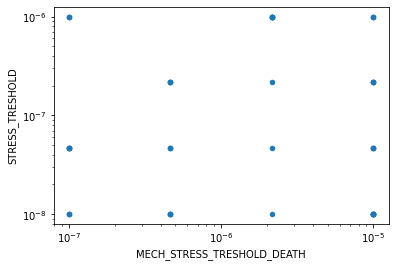

In [129]:
df = pd.DataFrame(parameters, columns=problem["names"])

scatterplot(1, 2, df, problem, param_info)

## Run simulations

In [38]:
def run_biocellion(param_vector, problem, param_info, model_folder):
    for i, parameter in enumerate(param_vector):
        print(i, parameter)
        parameter_loc = model_folder / param_info["file"][i]
        enter_parameter(parameter, parameter_loc, model_folder)
    
def enter_parameter(parameter, parameter_loc, model_folder):
    print(parameter_loc)
    

In [39]:
# for param in param_values:
run_biocellion(parameters[0], problem, param_info, ABM_CFD_MODEL_FOLDER)

0 1.0
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/model_define.h
1 1e-07
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/model_define.h
2 1e-06
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/model_define.h
3 220.0
/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/model_routine_config.cpp
